## 1. Importing Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import sklearn
import shap
import keras
import random

%matplotlib inline
import seaborn as sns
import time
import pickle
import kagglehub
from PIL import Image
sns.set()

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from keras import backend as K
import matplotlib.pyplot as plt

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

d:\DOMS\PP_PREP\9_XRay_CNN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Loading the dataset and images

In [2]:
import pandas as pd
import os

# --- Define the path to your new, clean project folder ---
project_path = r'D:\XRay_Project'

# --- Corrected paths to your files ---
csv_path = os.path.join(project_path, 'Data_Entry_2017.csv')
images_dir = os.path.join(project_path, 'images')

# --- Verification Script ---
print(f"Verifying data paths in: {project_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"✅ Successfully loaded CSV file.")
    
    if os.path.isdir(images_dir):
        print(f"✅ Successfully found images directory.")
        print("\n✅ All checks passed! You are ready to proceed.")
    else:
        print(f"❌ ERROR: The images directory does not exist at: {images_dir}")

except Exception as e:
    print(f"❌ An error occurred: {e}")

Verifying data paths in: D:\XRay_Project
✅ Successfully loaded CSV file.
✅ Successfully found images directory.

✅ All checks passed! You are ready to proceed.


Project Path: D:\XRay_Project
CSV Path: D:\XRay_Project\Data_Entry_2017.csv
Images Path: D:\XRay_Project\images

Loading and filtering data...
Found 4999 corresponding images and labels.

Split sizes -> Train: 3691, Validation: 314, Test: 994

--- Verifying No Data Leakage ---
No patient leakage detected between sets.
No patient leakage detected between sets.
No patient leakage detected between sets.

--- Example of a full image path ---
D:\XRay_Project\images\00000001_000.png

--- Analyzing Disease Distribution in Training Set ---


C:\Users\rishu\AppData\Local\Temp\ipykernel_12752\2850590037.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['full_path'] = train_df['Image Index'].apply(lambda x: os.path.join(images_dir, x))
C:\Users\rishu\AppData\Local\Temp\ipykernel_12752\2850590037.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['full_path'] = val_df['Image Index'].apply(lambda x: os.path.join(images_dir, x))
C:\Users\rishu\AppData\Local\Temp\ipykernel_12752\2850590037.py:67: SettingWithCopyWarning: 
A value i

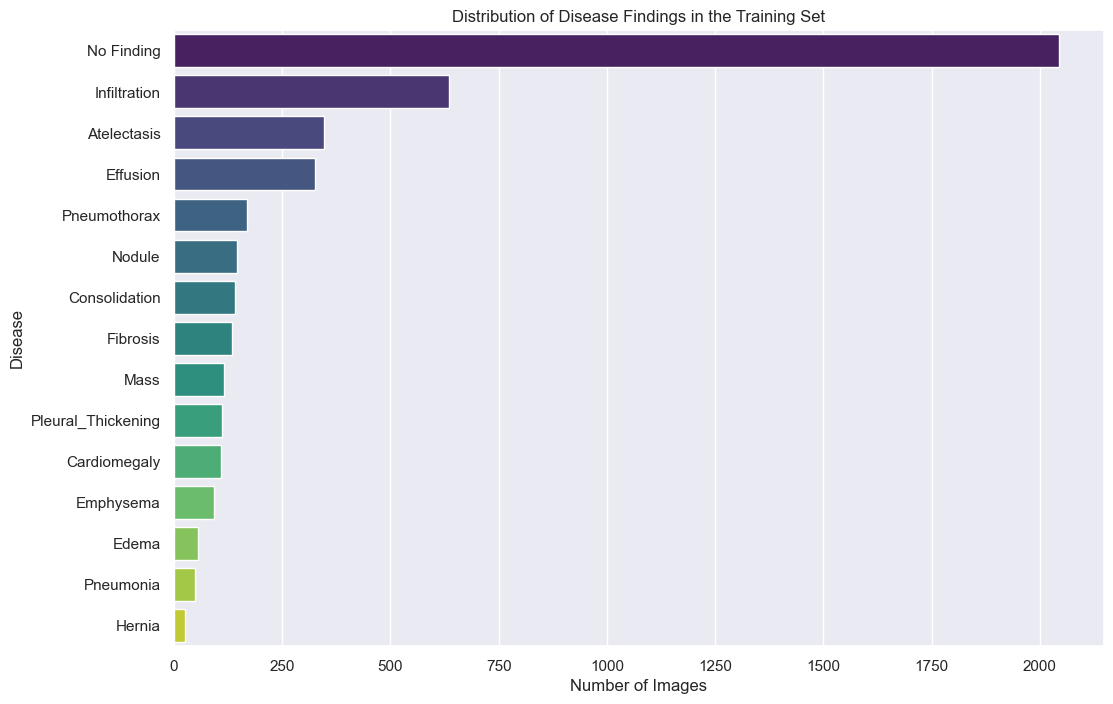


--- Displaying 9 Random Images from the Training Set ---


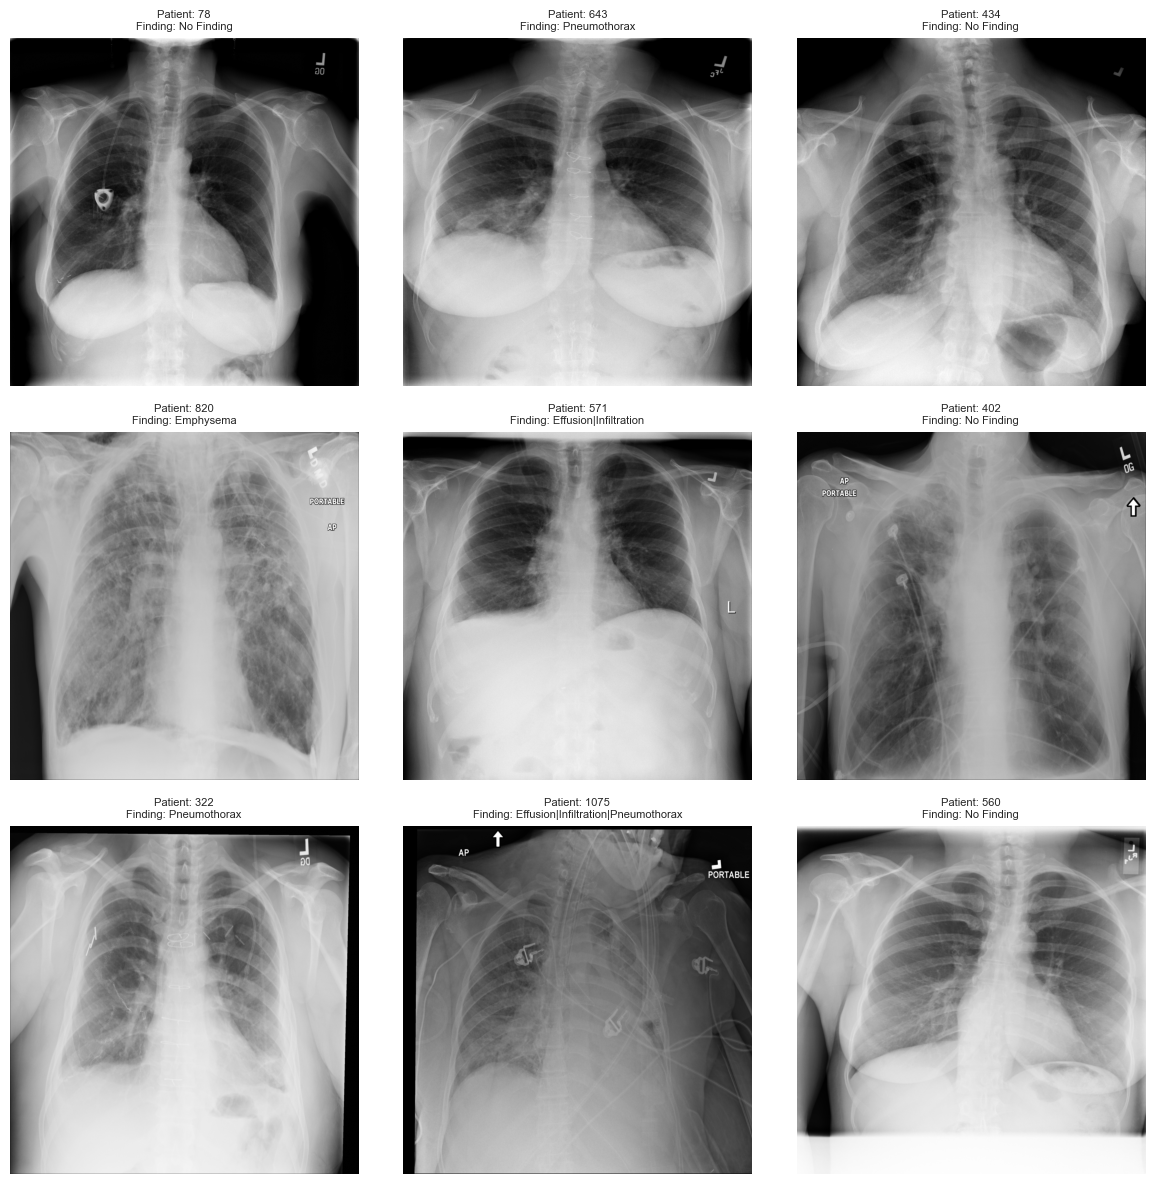

In [3]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 1. Define Paths for Your Local Setup ---
# These paths point directly to your data in the D:\XRay_Project folder.
project_path = r'D:\XRay_Project'
csv_path = os.path.join(project_path, 'Data_Entry_2017.csv')
images_dir = os.path.join(project_path, 'images')

print(f"Project Path: {project_path}")
print(f"CSV Path: {csv_path}")
print(f"Images Path: {images_dir}")

# --- 2. Load the DataFrame and Filter for Available Images ---
print("\nLoading and filtering data...")
df = pd.read_csv(csv_path)

# Get a list of all image filenames you have in your 'images' folder
available_images = set(os.listdir(images_dir))

# Keep only the rows in the DataFrame that correspond to an image you have downloaded
df = df[df["Image Index"].isin(available_images)].reset_index(drop=True)
print(f"Found {len(df)} corresponding images and labels.")

# --- 3. Split Data into Training, Validation, and Test Sets ---
# We perform a patient-aware split to prevent data leakage.
# First, get unique patient IDs
patient_ids = df['Patient ID'].unique()

# Split patient IDs
train_pats, test_pats = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_pats, val_pats = train_test_split(train_pats, test_size=0.1, random_state=42) # 10% of training for validation

# Create the dataframes based on the patient ID splits
train_df = df[df['Patient ID'].isin(train_pats)]
val_df = df[df['Patient ID'].isin(val_pats)]
test_df = df[df['Patient ID'].isin(test_pats)]

print(f"\nSplit sizes -> Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# --- 4. Data Leakage Check ---
def check_for_leakage(df1, df2, patient_col="Patient ID"):
    """Checks for overlapping patients between two dataframes."""
    df1_pats = set(df1[patient_col])
    df2_pats = set(df2[patient_col])
    overlap = df1_pats.intersection(df2_pats)
    if len(overlap) > 0:
        print(f"Leakage detected! {len(overlap)} patients overlap.")
        return True
    else:
        print(f"No patient leakage detected between sets.")
        return False

print("\n--- Verifying No Data Leakage ---")
check_for_leakage(train_df, val_df)
check_for_leakage(train_df, test_df)
check_for_leakage(val_df, test_df)

# --- 5. Add Full Image Paths to DataFrames ---
# This makes it much easier to load images later.
train_df['full_path'] = train_df['Image Index'].apply(lambda x: os.path.join(images_dir, x))
val_df['full_path'] = val_df['Image Index'].apply(lambda x: os.path.join(images_dir, x))
test_df['full_path'] = test_df['Image Index'].apply(lambda x: os.path.join(images_dir, x))

print("\n--- Example of a full image path ---")
print(train_df.head(1)['full_path'].values[0])


# --- 6. Explore and Visualize the Labels ---
print("\n--- Analyzing Disease Distribution in Training Set ---")
# The 'Finding Labels' column contains multiple diseases separated by '|'
# We'll split them to count each one individually
all_labels = train_df['Finding Labels'].str.split('|').explode()

# Plot the distribution
plt.figure(figsize=(12, 8))
sns.countplot(y=all_labels, order=all_labels.value_counts().index, palette="viridis")
plt.title('Distribution of Disease Findings in the Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Disease')
plt.show()


# --- 7. Visualize Sample Images ---
print("\n--- Displaying 9 Random Images from the Training Set ---")
# Sample 9 random rows from the training dataframe
sample_df = train_df.sample(9)

plt.figure(figsize=(12, 12))
for i, row in enumerate(sample_df.itertuples()):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(row.full_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Patient: {row._4}\nFinding: {row._2}", fontsize=8) # Patient ID and Finding Labels
    plt.axis('off')

plt.tight_layout()
plt.show()



Addressing Class Imbalance - Weighted Loss

One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

The plot clearly shows a significant class imbalance across the different conditions. The "No Finding" class is the most frequent, while pathologies like "Hernia" are extremely rare.

This imbalance is a major challenge. A model trained on this data may become biased towards predicting common conditions and perform poorly on rare ones. Ideally, a balanced dataset would be used to ensure both positive and negative cases contribute equally to the model's learning

## 3. Investigate a Single Image

script will take the very first image from your training set (train_df), display it, and print detailed metrics about its pixels, including a histogram.

Image Name: 00000001_000.png
Shape: 1024 x 1024
Channels: 1
Data type: float32
Min pixel value: 0.0000
Max pixel value: 1.0000
Mean pixel value: 0.5025
Std of pixel values: 0.2644


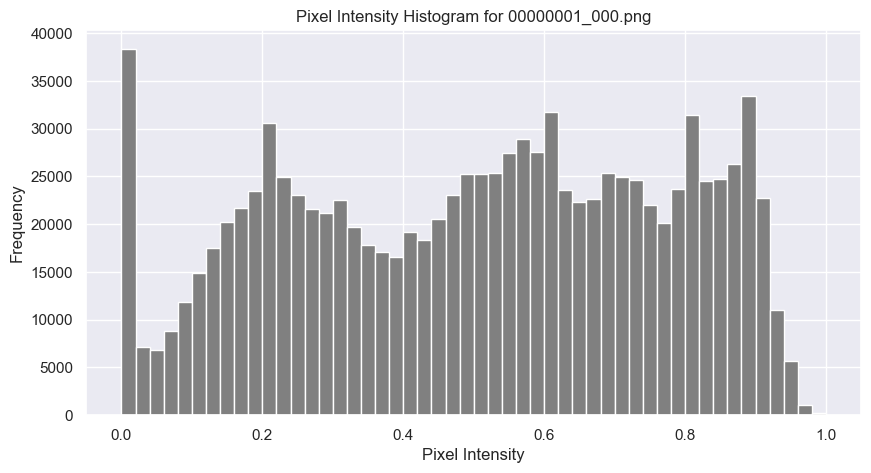

In [4]:
# --- Use your local image directory ---
images_dir = r'D:\XRay_Project\images'

# --- Dynamically get the first image from your training dataframe ---
# This ensures the image exists and is part of your training data.
first_image_name = train_df['Image Index'].iloc[0]
img_path = os.path.join(images_dir, first_image_name)

# --- Load and analyze the image ---
try:
    img = plt.imread(img_path)

    # Image metrics
    if img.ndim == 2:
        height, width = img.shape
        channels = 1
    else:
        height, width, channels = img.shape

    min_val, max_val = np.min(img), np.max(img)
    mean_val, std_val = np.mean(img), np.std(img)

    print(f"Image Name: {first_image_name}")
    print(f"Shape: {height} x {width}")
    print(f"Channels: {channels}")
    print(f"Data type: {img.dtype}")
    print(f"Min pixel value: {min_val:.4f}")
    print(f"Max pixel value: {max_val:.4f}")
    print(f"Mean pixel value: {mean_val:.4f}")
    print(f"Std of pixel values: {std_val:.4f}")

    # Pixel intensity histogram
    plt.figure(figsize=(10, 5))
    plt.hist(img.ravel(), bins=50, color='gray')
    plt.title(f'Pixel Intensity Histogram for {first_image_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

except FileNotFoundError:
    print(f"ERROR: The image '{first_image_name}' was not found at the path: {img_path}")
except Exception as e:
    print(f"An error occurred: {e}")

## 4. Positive Label Counts in Training Set

code calculates and displays the total number of positive cases for each disease in your training set (train_df). This is a crucial step for understanding the class imbalance.

In [5]:
# --- 1. Get all unique disease labels ---
# This is better done on the original 'df' to ensure all possible labels are included.
all_labels_list = sorted(list(df['Finding Labels'].str.split('|').explode().unique()))

print("All unique disease labels found:", all_labels_list)

# --- 2. Create Multi-Hot Encoded Columns for ALL DataFrames ---
# We apply this transformation to train, validation, and test sets so they have the same structure.
# Using .copy() helps avoid the 'SettingWithCopyWarning'.
for label in all_labels_list:
    train_df.loc[:, label] = train_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
    val_df.loc[:, label] = val_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
    test_df.loc[:, label] = test_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# --- 3. Calculate and Print Positive Label Counts from the Training Set ---
# This part of the logic remains the same.
disease_columns = [label for label in all_labels_list if label != 'No Finding']
positive_counts = train_df[disease_columns].sum()

print("\\nPositive Label Counts in the Training Set:\\n")
print(positive_counts)

# You can now re-run the Data Generator cell, and it will find the columns in val_df and test_df.

All unique disease labels found: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
\nPositive Label Counts in the Training Set:\n
Atelectasis           347
Cardiomegaly          110
Consolidation         141
Edema                  55
Effusion              325
Emphysema              92
Fibrosis              134
Hernia                 27
Infiltration          636
Mass                  117
Nodule                146
Pleural_Thickening    112
Pneumonia              50
Pneumothorax          168
dtype: int64


C:\Users\rishu\AppData\Local\Temp\ipykernel_12752\1509989969.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, label] = train_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
C:\Users\rishu\AppData\Local\Temp\ipykernel_12752\1509989969.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:, label] = val_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
C:\Users\rishu\AppData\Local\Temp\ipykernel_12752\1509989969.py:13: SettingWithCopyWarning: 
A value is 

## 5. Resizing the Image

We are processing a sample of images from your dataset by resizing them to a smaller dimension (128x128), normalizing their pixel values to a range, converting them to an 8-bit integer format for efficient storage, and saving the results as new PNG files in a writable output directory. This is a common preprocessing step in CNN workflows to prepare images for model training (e.g., reducing size for faster computation while preserving key features)

Q. Why This Step?

Preparation for CNN: Resizing reduces memory usage and speeds up training; normalization helps models converge faster.

Project Context: Builds on your earlier sampling/analysis cells, creating a dataset ready for data loaders (e.g., in PyTorch or TensorFlow).

Output: Prints save paths for each image; you can zip and download the folder from /kaggle/working if needed.

Train set resizing

In [6]:
import cv2
import os
from tqdm import tqdm

# --- 1. Define Configuration ---
# Set the desired image size and the output directory for resized images.
IMG_SIZE = (128, 128)
OUTPUT_DIR = os.path.join(project_path, 'processed_images')

# --- 2. Create the Output Directory ---
# This safely creates the folder if it doesn't already exist.
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Resized images will be saved in: {OUTPUT_DIR}")

# --- 3. Process and Resize Images ---
# We'll loop through the training dataframe with a progress bar (tqdm).
print("\\nProcessing training images...")

processed_count = 0
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        # Get the full path and the filename for the current image
        image_path = row['full_path']
        image_filename = row['Image Index']

        # Read the image in grayscale format (as it's a single channel)
        # This loads it as a NumPy array with pixel values from 0 to 255.
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded successfully
        if img is not None:
            # Resize the image to 128x128. INTER_AREA is best for shrinking.
            resized_img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

            # Construct the full path for the new, resized image
            output_path = os.path.join(OUTPUT_DIR, image_filename)

            # Save the resized image as a new PNG file.
            # The 8-bit integer format (uint8) is automatically handled by OpenCV for PNGs.
            cv2.imwrite(output_path, resized_img)
            processed_count += 1
        else:
            print(f"Warning: Could not read image at {image_path}")

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

print(f"\\n✅ Successfully processed and saved {processed_count} images.")

# You should repeat this process for your validation and test sets as well.
# for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
#     ... (same logic) ...
# for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
#     ... (same logic) ...

Resized images will be saved in: D:\XRay_Project\processed_images
\nProcessing training images...


100%|██████████| 3691/3691 [01:01<00:00, 60.06it/s]

\n✅ Successfully processed and saved 3691 images.


Validation and test set resizing

In [7]:
import cv2
import os
from tqdm import tqdm

# --- Re-define Configuration Just in Case ---
IMG_SIZE = (128, 128)
processed_images_dir = r'D:\XRay_Project\processed_images'
original_images_dir = r'D:\XRay_Project\images' # Path to original full-size images

# --- 1. Process and Resize Validation Images ---
print("--- Processing Validation Images ---")
for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
    try:
        image_path = os.path.join(original_images_dir, row['Image Index'])
        output_path = os.path.join(processed_images_dir, row['Image Index'])

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            resized_img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(output_path, resized_img)
    except Exception as e:
        print(f"Error processing {row['Image Index']}: {e}")

print(f"✅ Successfully processed {len(val_df)} validation images.")


# --- 2. Process and Resize Test Images ---
print("\n--- Processing Test Images ---")
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    try:
        image_path = os.path.join(original_images_dir, row['Image Index'])
        output_path = os.path.join(processed_images_dir, row['Image Index'])

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            resized_img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(output_path, resized_img)
    except Exception as e:
        print(f"Error processing {row['Image Index']}: {e}")

print(f"✅ Successfully processed {len(test_df)} test images.")

--- Processing Validation Images ---


100%|██████████| 314/314 [00:04<00:00, 68.67it/s]


✅ Successfully processed 314 validation images.

--- Processing Test Images ---


100%|██████████| 994/994 [00:14<00:00, 69.14it/s]

✅ Successfully processed 994 test images.


This code uses TensorFlow's ImageDataGenerator to prepare image data for a CNN. It normalizes pixel values to a 0-1 range and applies data augmentation, such as rotation and zoom, to the training set. It then creates generators to efficiently feed batches of images and labels from a DataFrame.

the data generators are set up correctly. The output shows that the image and label batches have the right shapes: (32, 128, 128, 1) for images and (32, 14) for the labels, which is exactly what the model expects.

Code for Training the CNN Model
This code will train the model you just compiled using the generators you just created. It also includes two very important components called callbacks:

ModelCheckpoint: Saves the best version of your model during training (based on validation performance).

EarlyStopping: Stops the training process automatically if the model is no longer improving, which saves time and prevents overfitting

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths & constants
processed_images_dir = r'D:\\XRay_Project\\processed_images'
IMG_SIZE, BATCH_SIZE = (128, 128), 32

# Labels from NIH-style "Finding Labels" (exclude "No Finding")
unique_labels = (train_df["Finding Labels"].str.split("|").explode().str.strip().dropna().unique())
disease_columns = sorted([lbl for lbl in unique_labels if lbl != "No Finding"])
print(f"Reading images from: {processed_images_dir}\nTarget Disease Labels ({len(disease_columns)}):\n{disease_columns}")

# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, zoom_range=0.15,
    width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.15, horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

def make_gen(df, datagen, shuffle, seed=None):
    return datagen.flow_from_dataframe(
        df, directory=processed_images_dir, x_col='Image Index', y_col=disease_columns,
        target_size=IMG_SIZE, color_mode='grayscale', class_mode='raw',
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=seed
    )

print("\nSetting up the training/validation/test generators...")
train_generator = make_gen(train_df, train_datagen, shuffle=True, seed=42)
validation_generator = make_gen(val_df, val_test_datagen, shuffle=False)
test_generator = make_gen(test_df, val_test_datagen, shuffle=False)

# Quick sanity check
x_batch, y_batch = next(train_generator)
print(f"Image batch shape: {x_batch.shape} | Label batch shape: {y_batch.shape}")


Reading images from: D:\\XRay_Project\\processed_images
Target Disease Labels (14):
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Setting up the training/validation/test generators...
Found 3691 validated image filenames.
Found 314 validated image filenames.
Found 994 validated image filenames.
Image batch shape: (32, 128, 128, 1) | Label batch shape: (32, 14)


## 6. Code for Standardization and Data Augmentation

 Here is the code to create an ImageDataGenerator that performs both standardization (mean subtraction and division by standard deviation) and data augmentation, and then uses it to prepare your datasets.

A key step for this type of normalization is to first fit the generator on a sample of your training data. This allows the generator to calculate the mean (μ) and standard deviation (σ) of the pixel values, which it will then use to normalize all the images.

This Works
Sequential Processing: Instead of trying to create a large array of images first, this code iterates through your sample file paths one by one.

Low Memory Footprint: It loads a single image, calculates its contribution to the overall mean and standard deviation, and then discards it before loading the next one. This keeps memory usage extremely low.

Direct Assignment: Once the loop is finished, we have the mean and std for the dataset. We then manually set these values on the image_generator, so it knows exactly how to standardize the images as it feeds them to the model.

This new MemoryError tells us that your environment is very memory-constrained. Even creating a single batch of 32 full-resolution (1024x1024) images is requiring 128 MiB of RAM, which is more than is available for that operation.

The previous approach of using a generator to fit was a good step, but the underlying Keras function still needs to create at least one full batch in memory to process it.

The Fix: Manual Statistics Calculation
The most memory-efficient solution is to calculate the mean and standard deviation manually by loading one image at a time. This process has a very small memory footprint, as you never hold more than one image in RAM.

Here is the revised code. This replaces the previous cell entirely and will solve the MemoryError.

Stastical Calculations 1500 images taken as sample

In [9]:
from pathlib import Path
import numpy as np
from PIL import Image

# Select a subset of training filenames
n_samples = 512  # 300–1000 is enough
sample_paths = [str(Path(processed_images_dir) / fn) 
                for fn in train_df['Image Index'].head(n_samples).tolist()]

# Load to RAM as (N,128,128,1) in 0–255
def read_gray_128(path):
    return np.array(Image.open(path).convert('L').resize((128,128)), dtype='float32')

X_sample = np.stack([read_gray_128(p) for p in sample_paths])[..., None]


In [10]:
from pathlib import Path
import numpy as np
from PIL import Image

# 1) Build a small list of file paths from your processed training set
n_samples = 512  # 300–1000 is plenty
sample_paths = [
    str(Path(processed_images_dir) / fname)
    for fname in train_df['Image Index'].head(n_samples).tolist()
]

# 2) Load images to a NumPy array in shape (N,128,128,1) with values 0–255
def load_grayscale_128(p):
    im = Image.open(p).convert('L').resize((128,128))
    return np.array(im, dtype='float32')  # 0–255

X_sample = np.stack([load_grayscale_128(p) for p in sample_paths], axis=0)
X_sample = X_sample[..., None]  # add channel dim

# 3) Fit the featurewise stats on rescaled data (generator handles rescale)
train_stdgen = ImageDataGenerator(rescale=1./255,
                                  featurewise_center=True,
                                  featurewise_std_normalization=True)
train_stdgen.fit(X_sample)  # learns mean/std

# 4) Reuse identical stats for val/test
val_stdgen = ImageDataGenerator(rescale=1./255)
val_stdgen.mean, val_stdgen.std = train_stdgen.mean, train_stdgen.std
test_stdgen = ImageDataGenerator(rescale=1./255)
test_stdgen.mean, test_stdgen.std = train_stdgen.mean, train_stdgen.std


In [11]:
import cv2, numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1) Mean/std from a sample (values in 0–1)
sample_df = train_df.sample(1500, random_state=42)
pix_sum = pix_sq = count = 0
for p in tqdm(sample_df['full_path']):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None: 
        continue
    x = img.astype(np.float32) / 255.0
    pix_sum += x.sum(); pix_sq += (x*x).sum(); count += x.size
mean = pix_sum / count; std = np.sqrt(pix_sq / count - mean**2)
print(f"Mean: {mean:.4f} | Std: {std:.4f}")

# 2) One generator with featurewise stats (reused for val)
gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
)
gen.mean, gen.std = mean, std

# 3) Factory to avoid repetition
def flow(df, shuffle):
    return gen.flow_from_dataframe(
        df, directory=None, x_col='full_path', y_col=[c for c in unique_labels if c != 'No Finding'],
        target_size=(128,128), color_mode='grayscale', class_mode='raw',
        batch_size=32, shuffle=shuffle, seed=42 if shuffle else None
    )

train_generator = flow(train_df, True)
validation_generator = flow(val_df, False)

# 4) Quick check
xb, yb = next(train_generator)
print(f"X: {xb.shape}, y: {yb.shape}, batch mean: {xb.mean():.4f}, batch std: {xb.std():.4f}")


100%|██████████| 1500/1500 [00:23<00:00, 64.16it/s]


Mean: 0.5127 | Std: 0.2527
Found 3691 validated image filenames.
Found 314 validated image filenames.
X: (32, 128, 128, 1), y: (32, 14), batch mean: 526.4979, batch std: 254.6625


Showing Comparisions after image processing

Yes—move all pixel scaling and standardization into the model using Keras preprocessing layers so every batch at train/val/test is on the same scale.

What to build
Rescaling layer to convert 0–255 to 0–1.

Normalization layer to apply global mean/variance (use the numbers already computed, or adapt on a representative dataset once).

Sigmoid head with binary cross-entropy for multi-label outputs.

Drop‑in model skeleton

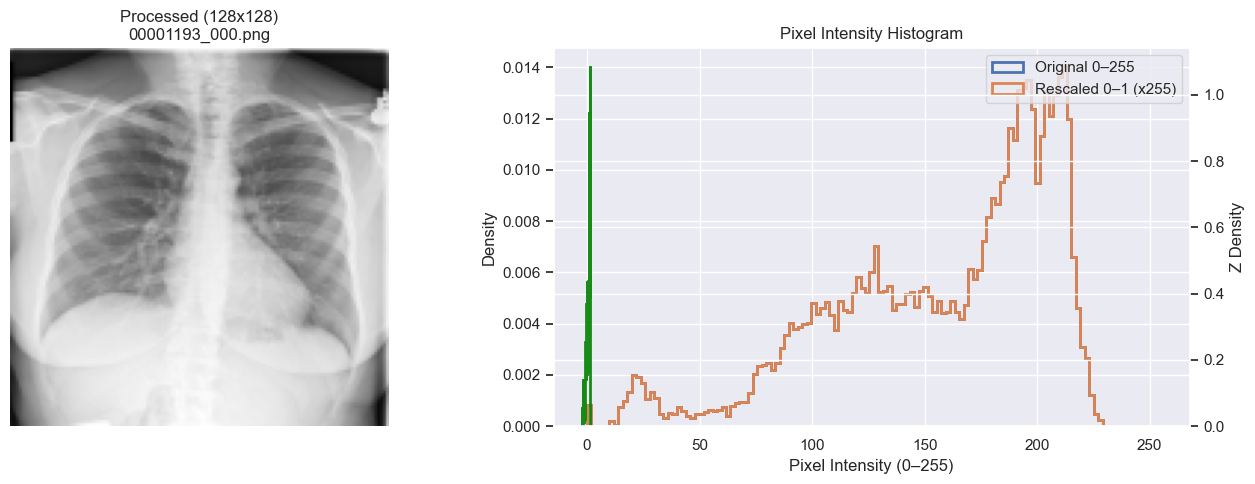

                     min         max        mean        std
original_0_255  0.000000  229.000000  158.424194  48.815717
rescaled_0_1    0.000000    0.898039    0.621271   0.191434
standardized_z -2.028887    1.524887    0.429645   0.757555
Found 3691 validated image filenames.
Found 314 validated image filenames.
raw generator batch dtype/range: float32 0.0 255.0
after Rescaling mean/std: 0.5219639 0.25226837
after Normalization mean/std: 0.036659792 0.998292


In [12]:
# 0) Imports
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, cv2, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1) Choose a random training image and visualize distributions after resizing
H, W = 128, 128
img_path = random.choice(train_df['full_path'].tolist())

orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
assert orig is not None, img_path
orig_resized = cv2.resize(orig, (W, H), interpolation=cv2.INTER_AREA)            # uint8 [0..255]
rescaled = orig_resized.astype(np.float32) / 255.0                               # [0..1]

# Compute dataset stats once (use your precomputed values)
MEAN, STD = 0.5127, 0.2527
standardized = (rescaled - MEAN) / (STD + 1e-7)                                  # z-score for demo

# Display why we normalize: histograms at each stage
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(14,5))
ax_img.imshow(rescaled, cmap='gray')
ax_img.set_title(f'Processed (128x128)\n{os.path.basename(img_path)}'); ax_img.axis('off')

bins = 128
ax_hist.hist(orig_resized.ravel(), bins=bins, range=(0,255), density=True, histtype='step', lw=2, label='Original 0–255')
ax_hist.hist((rescaled.ravel()*255.0), bins=bins, range=(0,255), density=True, histtype='step', lw=2, label='Rescaled 0–1 (x255)')
# Plot standardized on its native z-score axis for truthfulness
z = standardized.ravel()
ax2 = ax_hist.twinx()
ax2.hist(z, bins=bins, density=True, histtype='step', lw=2, color='green', label='Standardized z', alpha=0.9)
ax_hist.set_xlabel('Pixel Intensity (0–255)'); ax_hist.set_ylabel('Density'); ax_hist.grid(True)
ax_hist.set_title('Pixel Intensity Histogram')
ax_hist.legend(loc='upper right'); ax2.set_ylabel('Z Density')
plt.tight_layout(); plt.show()

# Small metrics table
def stats(x): return dict(min=float(np.min(x)), max=float(np.max(x)), mean=float(np.mean(x)), std=float(np.std(x)))
print(pd.DataFrame({'original_0_255': stats(orig_resized),
                    'rescaled_0_1':   stats(rescaled),
                    'standardized_z': stats(standardized)}).T)

# 2) Move normalization into the model with preprocessing layers
IMG_SHAPE = (H, W, 1)
NUM_LABELS = len([c for c in unique_labels if c != 'No Finding'])

inputs = layers.Input(shape=IMG_SHAPE, dtype='uint8')               # raw bytes from generator
x = layers.Rescaling(1./255)(inputs)                                # [0..1] scaling
x = layers.Normalization(mean=[MEAN], variance=[STD**2])(x)         # global z-score
# Example backbone (replace/extend as needed)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x); x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x);  x = layers.MaxPool2D()(x)
x = layers.Conv2D(128,3, padding='same', activation='relu')(x);  x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_LABELS, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(multi_label=True), 'accuracy'])

# 3) Generators without any scaling/standardization (model handles it)
plain_gen = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
)

disease_columns = [c for c in unique_labels if c != 'No Finding']

def flow(df, shuffle):
    return plain_gen.flow_from_dataframe(
        df, directory=None, x_col='full_path', y_col=disease_columns,
        target_size=(H, W), color_mode='grayscale', class_mode='raw',
        dtype='uint8', batch_size=32, shuffle=shuffle, seed=42 if shuffle else None
    )

train_generator = flow(train_df, True)
val_generator   = flow(val_df, False)

# 4) Sanity check: this batch should be bytes, but model’s first layers rescale+normalize
xb_raw, _ = next(train_generator)
print('raw generator batch dtype/range:', xb_raw.dtype, xb_raw.min(), xb_raw.max())

# 5) Optional: verify normalized batch via a forward pass of only the preprocessing
pre = tf.keras.Model(model.inputs, model.layers[1].output)  # up to Rescaling
pre2 = tf.keras.Model(model.inputs, model.layers[2].output) # up to Normalization
xb_scaled = pre.predict(xb_raw, verbose=0)
xb_normed = pre2.predict(xb_raw, verbose=0)
print('after Rescaling mean/std:', xb_scaled.mean(), xb_scaled.std())
print('after Normalization mean/std:', xb_normed.mean(), xb_normed.std())

# 6) Train when ready
# history = model.fit(train_generator, validation_data=val_generator, epochs=15)


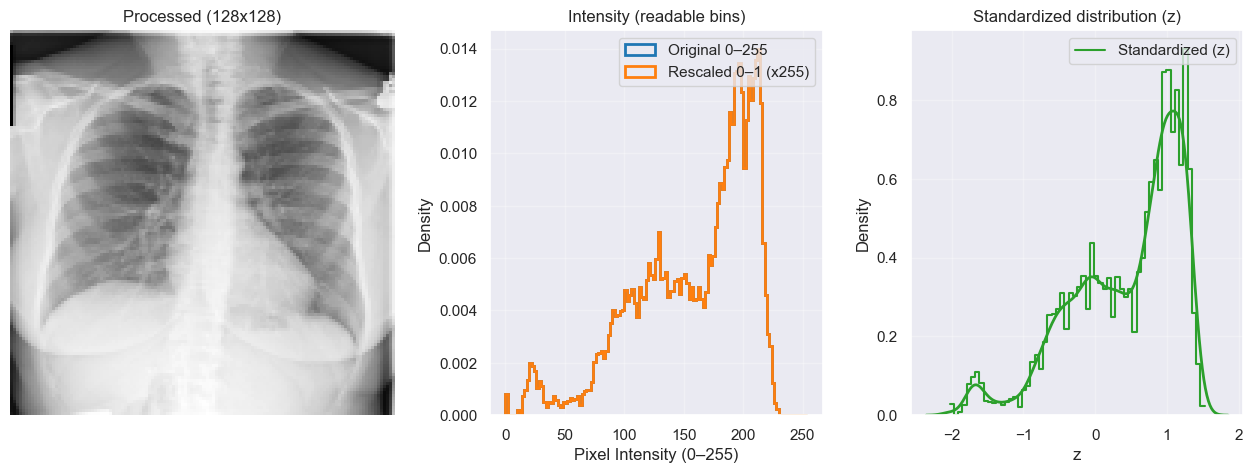

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Inputs prepared earlier: orig_resized (uint8 0–255), rescaled (0–1), standardized = (rescaled - MEAN)/STD
bins_255 = np.arange(0, 256, 2)  # coarser bins for readability

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1], wspace=0.25)

# A) Image preview
ax_img = fig.add_subplot(gs[0,0])
ax_img.imshow(rescaled, cmap='gray')
ax_img.set_title('Processed (128x128)')
ax_img.axis('off')

# B) Histogram: Original vs Rescaled (both on 0–255 axis)
ax_h = fig.add_subplot(gs[0,1])
ax_h.hist(orig_resized.ravel(), bins=bins_255, density=True,
          histtype='step', lw=2, color='tab:blue', label='Original 0–255')
ax_h.hist((rescaled.ravel()*255.0), bins=bins_255, density=True,
          histtype='step', lw=2, color='tab:orange', label='Rescaled 0–1 (x255)')
ax_h.set_title('Intensity (readable bins)')
ax_h.set_xlabel('Pixel Intensity (0–255)')
ax_h.set_ylabel('Density')
ax_h.legend(loc='upper right')
ax_h.grid(True, alpha=0.3)

# C) Standardized on true z-axis with KDE
ax_z = fig.add_subplot(gs[0,2])
z = standardized.ravel()
sns.histplot(z, bins=60, stat='density', element='step', fill=False,
             color='tab:green', ax=ax_z, label='Standardized (z)')
sns.kdeplot(z, color='tab:green', lw=2, ax=ax_z)  # smooth shape
ax_z.set_title('Standardized distribution (z)')
ax_z.set_xlabel('z')
ax_z.set_ylabel('Density')
ax_z.grid(True, alpha=0.3)
ax_z.legend(loc='upper right')

plt.show()


## Addressing Class Imbalance

             Class  Positive Frequency  Negative Frequency  w_pos  w_neg
      Infiltration              0.1723              0.8277 0.8277 0.1723
       Atelectasis              0.0940              0.9060 0.9060 0.0940
          Effusion              0.0881              0.9119 0.9119 0.0881
            Nodule              0.0396              0.9604 0.9604 0.0396
     Consolidation              0.0382              0.9618 0.9618 0.0382
          Fibrosis              0.0363              0.9637 0.9637 0.0363
              Mass              0.0317              0.9683 0.9683 0.0317
Pleural_Thickening              0.0303              0.9697 0.9697 0.0303
         Emphysema              0.0249              0.9751 0.9751 0.0249
             Edema              0.0149              0.9851 0.9851 0.0149
         Pneumonia              0.0135              0.9865 0.9865 0.0135
            Hernia              0.0073              0.9927 0.9927 0.0073


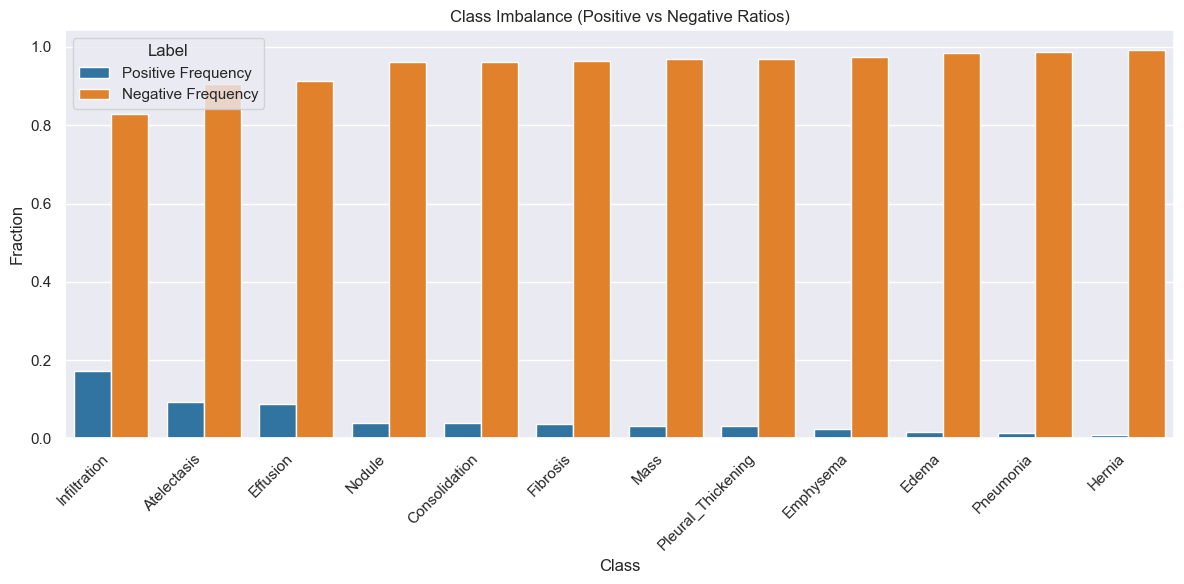

In [14]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# Classes
class_names = ['Emphysema','Effusion','Hernia','Infiltration','Mass','Nodule',
               'Atelectasis','Pleural_Thickening','Pneumonia','Fibrosis','Edema','Consolidation']

# Ensure one-hot columns on train_df (idempotent)
if 'Finding Labels' in train_df.columns:
    fl = train_df['Finding Labels'].fillna('').str.split('|')
    for c in class_names:
        if c not in train_df.columns:
            train_df[c] = fl.apply(lambda L: int(c in L))

# Frequencies and weights (sorted)
freq_pos = train_df[class_names].mean()
freq_neg = 1.0 - freq_pos
class_weights = pd.DataFrame({
    'Class': class_names,
    'Positive Frequency': freq_pos.values,
    'Negative Frequency': freq_neg.values,
    'w_pos': freq_neg.values,   # weight for positive cases
    'w_neg': freq_pos.values    # weight for negative cases
}).sort_values('Positive Frequency', ascending=False)

# Print once
with pd.option_context('display.max_rows', None, 'display.precision', 4):
    print(class_weights.to_string(index=False))

# Single readable plot
plot_df = class_weights.melt(id_vars='Class',
                             value_vars=['Positive Frequency','Negative Frequency'],
                             var_name='Label', value_name='Value')
plt.figure(figsize=(12,6)); sns.set_theme(style='darkgrid')
sns.barplot(data=plot_df, x='Class', y='Value', hue='Label',
            palette=['#1f77b4','#ff7f0e'])
plt.title('Class Imbalance (Positive vs Negative Ratios)')
plt.xticks(rotation=45, ha='right'); plt.ylabel('Fraction'); plt.xlabel('Class')
plt.tight_layout(); plt.show()



## Training the Model on Train set

In [15]:
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 0) Inputs from previous steps
IMG_SIZE = (128, 128)
NUM_LABELS = len([c for c in class_weights['Class']])
DISEASE_COLS = class_weights['Class'].tolist()  # same ordering as weights

# 1) Build the model with preprocessing layers
MEAN, STD = 0.5127, 0.2527  # your computed dataset stats
inputs = layers.Input(shape=(*IMG_SIZE, 1), dtype='uint8')
x = layers.Rescaling(1./255)(inputs)
x = layers.Normalization(mean=[MEAN], variance=[STD**2])(x)

# small CNN backbone (replace with your preferred architecture)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x); x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x); x = layers.MaxPool2D()(x)
x = layers.Conv2D(128,3, padding='same', activation='relu')(x); x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_LABELS, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(multi_label=True), 'accuracy'])

# 2) Generators without scaling (model handles it)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
)
plain = ImageDataGenerator()

def flow(df, gen, shuffle):
    return gen.flow_from_dataframe(
        df, directory=None, x_col='full_path', y_col=DISEASE_COLS,
        target_size=IMG_SIZE, color_mode='grayscale', class_mode='raw',
        dtype='uint8', batch_size=32, shuffle=shuffle, seed=42 if shuffle else None
    )

train_generator = flow(train_df, aug, True)
val_generator   = flow(val_df, plain, False)

# 3) Optional per-sample weights from per-class prevalence
#    We convert per-class weights to per-sample weights: w = sum_j ( y_ij * w_pos_j + (1 - y_ij) * w_neg_j ) / NUM_LABELS
w_pos = class_weights.set_index('Class').loc[DISEASE_COLS, 'w_pos'].values  # shape (C,)
w_neg = class_weights.set_index('Class').loc[DISEASE_COLS, 'w_neg'].values  # shape (C,)

def sample_weight_fn(y_batch):
    # y_batch: (B, C) in {0,1}
    return np.mean(y_batch * w_pos + (1 - y_batch) * w_neg, axis=1).astype('float32')  # (B,)

# Keras Sequence wrapper to inject sample_weight
def gen_with_weights(gen):
    for xb, yb in gen:
        yield xb, yb, sample_weight_fn(yb)

train_gen_w = gen_with_weights(train_generator)

# 4) Callbacks for stable training
callbacks = [
    EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('xray_cnn_best.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1),
]

# 5) Fit
steps_per_epoch = len(train_generator)
history = model.fit(
    train_gen_w,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1,
)


Found 3691 validated image filenames.
Found 314 validated image filenames.
Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3278 - auc_1: 0.5077 - loss: 0.0348

d:\DOMS\PP_PREP\9_XRay_CNN\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 77s 646ms/step - accuracy: 0.4403 - auc_1: 0.5086 - loss: 0.0293 - val_accuracy: 0.7516 - val_auc_1: 0.4186 - val_loss: 0.2116 - learning_rate: 0.0010
Epoch 2/30


d:\DOMS\PP_PREP\9_XRay_CNN\venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_1,loss,val_accuracy,val_auc_1,val_loss
  current = self.get_monitor_value(logs)
d:\DOMS\PP_PREP\9_XRay_CNN\venv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_1,loss,val_accuracy,val_auc_1,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
d:\DOMS\PP_PREP\9_XRay_CNN\venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


116/116 ━━━━━━━━━━━━━━━━━━━━ 73s 629ms/step - accuracy: 0.5378 - auc_1: 0.5177 - loss: 0.0265 - val_accuracy: 0.5000 - val_auc_1: 0.4108 - val_loss: 0.1884 - learning_rate: 0.0010
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 76s 656ms/step - accuracy: 0.5662 - auc_1: 0.5249 - loss: 0.0261 - val_accuracy: 0.7516 - val_auc_1: 0.4257 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 72s 623ms/step - accuracy: 0.6185 - auc_1: 0.5194 - loss: 0.0259 - val_accuracy: 0.7516 - val_auc_1: 0.4619 - val_loss: 0.1909 - learning_rate: 0.0010
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 612ms/step - accuracy: 0.6375 - auc_1: 0.5357 - loss: 0.0256 - val_accuracy: 0.7516 - val_auc_1: 0.4566 - val_loss: 0.1924 - learning_rate: 0.0010
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 615ms/step - accuracy: 0.6483 - auc_1: 0.5336 - loss: 0.0255 - val_accuracy: 0.7516 - val_auc_1: 0.4811 - val_loss: 0.1885 - learning_rate: 0.0010
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 70s 611ms/step -

## Densenet Training after optimisation

In [16]:
"""# Single cell: fast DenseNet121 training on 3691 train / 314 val
# - tf.data with AUTOTUNE + prefetch for speed
# - In-model rescale/standardize + train-time augmentation
# - Freeze→unfreeze with strict EarlyStopping(baseline) to stop early
# - Live logs every 25 steps and per-epoch metrics

import os, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers.schedules import CosineDecay

# Mixed precision (safe speedup on supported GPUs)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Assumed precomputed inputs in the notebook:
# train_df, val_df, class_weights with columns ['Class','w_pos','w_neg'] and file paths in 'full_path'
LABELS = class_weights['Class'].tolist(); C = len(LABELS)
MEAN, STD = 0.5127, 0.2527
IMG_SIZE = (128, 128)
BATCH = 32  # raise to 48 or 64 if memory allows for fewer steps/epoch

# Build file/label tensors
train_files = train_df['full_path'].astype(str).values
val_files   = val_df['full_path'].astype(str).values
y_train = train_df[LABELS].values.astype('float32')
y_val   = val_df[LABELS].values.astype('float32')

# Per-class weights -> per-sample weight scalar (computed in tf.data map)
w_pos = tf.constant(class_weights.set_index('Class').loc[LABELS, 'w_pos'].values.astype('float32'))
w_neg = tf.constant(class_weights.set_index('Class').loc[LABELS, 'w_neg'].values.astype('float32'))

# tf.data pipeline: decode -> resize -> uint8 -> (x, y, sample_weight)
AUTOTUNE = tf.data.AUTOTUNE
def decode_resize_uint8(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, method='bilinear')
    img = tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8)
    return img

def make_ds(paths, labels, training):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: (decode_resize_uint8(p), y), num_parallel_calls=AUTOTUNE)
    # per-sample scalar weight: mean over classes of class-wise weights
    def add_weight(x, y):
        sw = tf.reduce_mean(y * w_pos + (1.0 - y) * w_neg, axis=1)  # (batch,) after batching
        return x, y, sw
    ds = ds.batch(BATCH, drop_remainder=False).map(add_weight, num_parallel_calls=AUTOTUNE)
    # Performance options
    opts = tf.data.Options()
    opts.experimental_deterministic = False  # allow out-of-order for speed
    ds = ds.with_options(opts).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_files, y_train, training=True)
val_ds   = make_ds(val_files,   y_val,   training=False)

# Model: in-model preprocessing, augmentation (train-only), DenseNet121 backbone, sigmoid head
def build_model():
    inp = layers.Input(shape=(*IMG_SIZE, 1), dtype='uint8')
    x = layers.Rescaling(1./255., name='rescale')(inp)
    x = layers.Lambda(lambda t: (t - MEAN) / STD, name='standardize')(x)
    x = layers.Lambda(lambda t: tf.image.grayscale_to_rgb(t), name='gray_to_rgb')(x)
    # Light on-the-fly augmentation (active only during training)
    aug = keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05),
        layers.RandomTranslation(0.05, 0.05),
    ], name='augment')
    x = aug(x)
    base = DenseNet121(weights='imagenet', include_top=False, pooling='avg', name='densenet121')
    base.trainable = False
    x = base(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(C, activation='sigmoid', dtype='float32', name='pred')(x)  # keep head in float32 under AMP
    m = models.Model(inp, out)
    m.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc', multi_label=True, num_labels=C)]
    )
    return m

model = build_model()

# Live logging callbacks: per-epoch LR and compact per-batch prints every 25 steps
class LogLR(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        val = float(lr(self.model.optimizer.iterations)) if callable(lr) else float(keras.backend.get_value(lr))
        if logs is not None: logs['learning_rate'] = val
        print(f"\nEpoch {epoch+1}: learning_rate={val:.6g}", flush=True)

class Heartbeat(keras.callbacks.Callback):
    def __init__(self, every=25): super().__init__(); self.every = every; self.k = 0
    def on_epoch_begin(self, epoch, logs=None): self.k = 0
    def on_train_batch_end(self, batch, logs=None):
        self.k += 1
        if self.k % self.every == 0:
            lr = self.model.optimizer.learning_rate
            val = float(lr(self.model.optimizer.iterations)) if callable(lr) else float(keras.backend.get_value(lr))
            print(f"step {self.k}: loss={logs.get('loss',0):.4f}, auc={logs.get('auc',0):.4f}, lr={val:.2e}", flush=True)

ckpt = ModelCheckpoint('d121_best_auc.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Phase 1: short head training (frozen backbone)
es_head = EarlyStopping(monitor='val_auc', mode='max', patience=2, restore_best_weights=True)
hist_head = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[ckpt, es_head, LogLR(), Heartbeat(25)], verbose=2)

# Phase 2: fine-tune all with cosine decay; strict EarlyStopping baseline to exit fast if no gain
baseline = float(np.max(hist_head.history.get('val_auc', [0.0])))
model.get_layer('densenet121').trainable = True
steps = tf.data.experimental.cardinality(train_ds).numpy()
cos = CosineDecay(initial_learning_rate=1e-4, decay_steps=max(1, steps * 12), alpha=1e-2)
model.compile(optimizer=keras.optimizers.Adam(cos),
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc', multi_label=True, num_labels=C)])
es_ft = EarlyStopping(monitor='val_auc', mode='max', patience=2, min_delta=1e-3, baseline=baseline, restore_best_weights=True)
hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[ckpt, es_ft, LogLR(), Heartbeat(25)], verbose=2)

# Load the best checkpoint at the end
model = keras.models.load_model('d121_best_auc.keras')
print("Training complete. Best checkpoint restored from d121_best_auc.keras", flush=True)
"""

'# Single cell: fast DenseNet121 training on 3691 train / 314 val\n# - tf.data with AUTOTUNE + prefetch for speed\n# - In-model rescale/standardize + train-time augmentation\n# - Freeze→unfreeze with strict EarlyStopping(baseline) to stop early\n# - Live logs every 25 steps and per-epoch metrics\n\nimport os, numpy as np, tensorflow as tf\nfrom tensorflow import keras\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.applications import DenseNet121\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger\nfrom tensorflow.keras.optimizers.schedules import CosineDecay\n\n# Mixed precision (safe speedup on supported GPUs)\ntf.keras.mixed_precision.set_global_policy(\'mixed_float16\')\n\n# Assumed precomputed inputs in the notebook:\n# train_df, val_df, class_weights with columns [\'Class\',\'w_pos\',\'w_neg\'] and file paths in \'full_path\'\nLABELS = class_weights[\'Class\'].tolist(); C = len(LABELS)\nMEAN, STD = 0.5127, 0.2527\nIMG_SIZE = (128,